# Fourier Transform

**Description:** The Discrete Fourier Transform(DFT) and Fast Fourier Transform(FFT) are methods of representing signals as a sum of sinusoids. This notebook demonstrates the mechanisms of DFT/FFT as well as the reconstruction of a signal

**Example Description**: This example demonstrates:

- Producing a cosine wave
- Taking the DFT or FFT of the cosine wave
- Reconstructing the cosine wave from a handful of DFT terms

To start, let us import some useful math libs

In [1039]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import Markdown as md
import numpy.linalg as lin
from pandas import DataFrame

### Drawing a basic cosine wave

Next, lets create a basic cosine wave that is defined by an **amplitude, frequency, phase shift, and offset**.

In [1040]:
b = 3 # Offset
freq = 5 # Frequency 
phase = math.pi*(3/4) # Phase 
a = 2 # Amplitude 
res = 0.01
theta = np.arange(0,2*np.pi,res)
theta = theta if len(theta) % 2 == 0 else theta[0:len(theta)-1] 
y = a*np.sin(freq*theta+phase)+b # Equation 
md("<h3>Cosine Properties:</h3>Amplitude is %3.3f<br> Offset is %3.3f<br>Frequency is %3.3f<br>Phase is %3.3f<br>Equation is: $y=%3.3f \cdot cos(%3.3f \cdot \\theta + %3.3f)+%3.3f$"%(a,b,freq,phase,a,freq,phase,b))


<h3>Cosine Properties:</h3>Amplitude is 2.000<br> Offset is 3.000<br>Frequency is 5.000<br>Phase is 2.356<br>Equation is: $y=2.000 \cdot cos(5.000 \cdot \theta + 2.356)+3.000$

### Next, plot the cosine

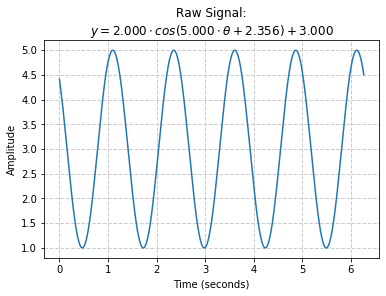

In [1041]:
plt.plot(theta,y)
plt.title('Raw Signal:\n$y=%3.3f \cdot cos(%3.3f \cdot \\theta + %3.3f)+%3.3f$'%(a,freq,phase,b))
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
plt.grid(color='0.8', linestyle='--', linewidth=1)

# Discrete Fourier Transform 

The Discrete Fourier Transform(DFT) is a simple transform to perform which can convert an arbitrary set of data into its frequency components. **Note:** Opperationally speaking one should use Fast Fourier Transform(FFT) which can be significantly more computationally efficent at scale. However, as shown below, the DFT is quite simple mathematically and to program:   

$
DFT[k] = \bigg| \sum^{N-1}_{n=0} \sum^{N-1}_{K=0}x[n] \cdot e^{-j \frac{2 \pi k n}{N}} \bigg|
$


In [1042]:
# Discrete Fourier Transform 
def dft(data):
    N = len(data)
    out = np.zeros(N,dtype=complex)
    for n in range(N):
        for k in range(N):
            out[k] = out[k] + data[n]*np.exp((-1j*2*np.pi*k*n)/N)
    return out

### Perform the DFT | FFT and plot

FT Results:
                        0
0   1883.534884+0.000000j
1     -0.484054-0.093167j
2     -0.551704-0.212979j
3     -0.720917-0.419443j
4     -1.274574-0.995405j
5  447.455846+440.619762j
6      1.017413+1.215191j
7      0.460902+0.650529j
8      0.279490+0.457643j
9      0.191322+0.358575j


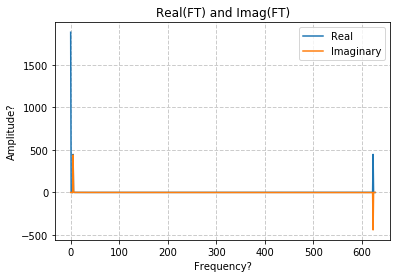

In [1043]:
#res = np.fft.fft(y) # More computationally efficent fft 
res = dft(y)
print('FT Results:')
print(DataFrame(res[0:10]))
plt.plot(np.real(res))
plt.plot(np.imag(res))
plt.legend(['Real','Imaginary'])
plt.title('Real(FT) and Imag(FT)')
plt.xlabel('Frequency?')
plt.ylabel('Amplitude?')
plt.grid(color='0.8', linestyle='--', linewidth=1)


### Cleanup FT

As observed, the output of the FT is simply an array of complex numbers. When one plots the real and imaginary portions of the FT, the spikes are oddly disjointed occuring at the front and end of the plot. This is because midway through the FT, the results represent the negative frequency components. 

Lets clean up the FT plot into something more readible:

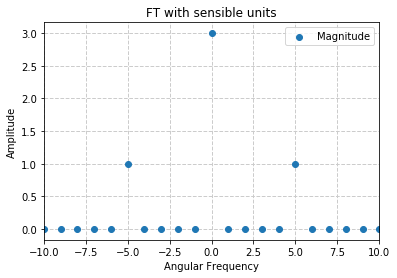

In [1044]:
fig, ax = plt.subplots()
yfftr = np.real(res)
yr = res[0:int(len(res)/2)]
yi = res[int(len(res)/2):len(res)]
yfftr = np.concatenate([yi,yr]) #  Reflect negative signal portion 
x = np.arange(-int(len(res)/2),int(len(res)/2))/(max(theta)/(2*np.pi)) # x axis is fractions of 2pi period. E.g. 
res_scaled = (np.real(yfftr)**2 + np.imag(yfftr)**2)**(1/2)/len(res) # Norm of signal 
ax.scatter(x,res_scaled)
ax.set_xlim(-freq*2,freq*2)
ax.set_axisbelow(True)
ax.legend(['Magnitude'])
ax.set_xlabel('Angular Frequency')
ax.set_ylabel('Amplitude')
ax.set_title('FT with sensible units')
ax.grid(color='0.8', linestyle='--', linewidth=1)

Right away we notice the offet at the 0 frequency. Also, **half** the amplitude is also represented at the +- frequency points. The FT output is rather raw, below are the equations to abstract the key information from a FT array:   

### Retreive Amplitude, Phase, and Frequency from FT

Amplitude = $\frac{\sqrt{Re(FT)^2 + Im(FT)^2)}}{N} $ <br><br>
Phase = $ATAN2(\frac{Im(FT)}{Re(FT})$ <br><br>
Frequency Steps = $ [(0:N/2),(-N/2:0)] \cdot (\frac{T}{2\pi}) $ 

In [1045]:
#res_angle = np.angle(res)
res_angle = np.arctan2(np.imag(res),np.real(res))
res_amp = (np.real(res)**2 + np.imag(res)**2)**(1/2)/len(res)
res_freq = np.concatenate([np.arange(0,int(len(res)/2)),np.arange(-int(len(res)/2),0)])*(2*np.pi/max(theta))
fft_res = np.array([res_amp,res_angle,res_freq]).T
fft_sort = fft_res[fft_res[:,0].argsort()]
fft_sort = np.flipud(fft_sort)

fft_n = 5 # Use this amount of samples to represent signal 

print('Top ' + str(fft_n) + ' FFT samples')
print(DataFrame(fft_sort[:fft_n], columns=['Amplitude',"Phase",'Frequency']))

Top 5 FFT samples
   Amplitude     Phase  Frequency
0   2.999259  0.000000   0.000000
1   0.999973 -0.777701  -5.010515
2   0.999973  0.777701   5.010515
3   0.002575  2.478563  -4.008412
4   0.002575 -2.478563   4.008412


Note how the negative and positive components are redundant. One could further optimize by simply taking the positive components and scaling by 2 (except for the offset).

### Reconstruct original signal from a part of the FT

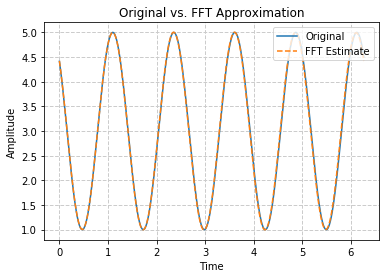

In [1046]:
y_fft = np.ones([1,fft_n]) @ (np.array([fft_sort[0:fft_n,0]]).T * np.cos(np.array([fft_sort[0:fft_n,2]]).T * theta + np.array([fft_sort[0:fft_n,1]]).T  * (theta*0+1) )) 
y_fft = y_fft.flatten()
plt.plot(theta,y)
plt.plot(theta,y_fft,'--')
plt.legend(['Original','FFT Estimate'],loc='upper right')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title('Original vs. FFT Approximation')
plt.grid(color='0.8', linestyle='--', linewidth=1)

Not surpisingly a sinusoid can be well represented as a sum of sinusoids.

### Representation of 2D space

Consider a more unique example of trying to represent a 2D path with a FT. For this example, a square will be modeled with an FT. 

### Generate Square

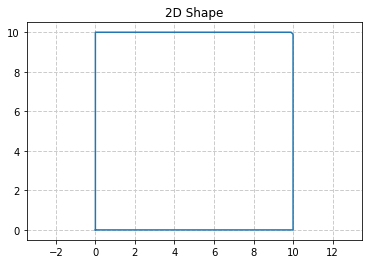

In [1053]:
dist = 10
seg = 0.1
fig, ax = plt.subplots()
seg_x = np.array([np.arange(0,dist,seg)])
seg_1 = np.block([[seg_x],[0*seg_x]])
seg_2 = np.block([[0*seg_x + dist],[seg_x]])
seg_3 = np.block([[np.flip(seg_x)],[seg_x*0 + dist]])
seg_4 = np.block([[seg_x*0],[np.flip(seg_x)]])
route = np.block([[seg_1,seg_2,seg_3,seg_4]])
route = route.T
ax.plot(route[:,0],route[:,1])
ax.axis('equal')
plt.title('2D Shape')
ax.grid(color='0.8', linestyle='--', linewidth=1)


### Take FT of shape

In [1051]:
route_p = np.array(route[:,0] + 1j*route[:,1]) # Define route in terms of real & imaginary 
res_s = dft(route_p) # Take FFT
res_ang_s = np.arctan2(np.imag(res_s),np.real(res_s))
res_amp_s = (np.real(res_s)**2 + np.imag(res_s)**2)**(1/2)/len(res_s)
res_freq_s = np.concatenate([np.arange(0,int(len(res_s)/2)),np.arange(-int(len(res_s)/2),0)])*(2*np.pi/len(route_p))
fft_res_s = np.array([res_amp_s,res_ang_s,res_freq_s]).T
fft_sort_s = fft_res_s[fft_res_s[:,0].argsort()]
fft_sort_s = np.flipud(fft_sort_s)

fft_n = 5 # Use this amount of samples to represent signal 

print('Top ' + str(fft_n) + ' FFT samples')
print(DataFrame(fft_sort_s[:fft_n], columns=['Amplitude',"Phase",'Frequency']))

Top 5 FFT samples
   Amplitude     Phase  Frequency
0   7.035712  0.785398   0.000000
1   5.731533 -2.348341   0.015708
2   0.636785 -2.379756  -0.047124
3   0.229205 -2.316925   0.078540
4   0.116912 -2.411172  -0.109956


### Plot FT for N-Terms

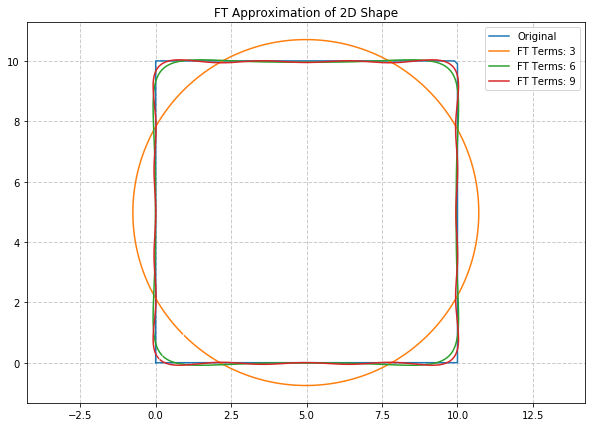

In [1054]:
theta = np.arange(0,400,1)

fig, ax = plt.subplots()
ax.plot(route[:,0],route[:,1],label='Original')

for i in range(3):
    fft_n = i*3 + 2
    amp = np.array([fft_sort_s[0:fft_n,0]]).T
    phase = np.array([fft_sort_s[0:fft_n,1]]).T  * (theta*0+1)
    freq = np.array([fft_sort_s[0:fft_n,2]]).T
    x_fft = np.ones([1,fft_n]) @ (amp * np.cos(( freq * theta + phase ))) 
    y_fft = np.ones([1,fft_n]) @ (amp * np.sin(( freq * theta + phase )))
    ax.plot(x_fft.T,y_fft.T,label='FT Terms: ' + str(fft_n+1))

ax.legend(loc='upper right')
ax.axis('equal')
plt.title('FT Approximation of 2D Shape')
fig.set_size_inches(10,7)
ax.grid(color='0.8', linestyle='--', linewidth=1)

As observed, the more terms that are used, the better the approximation of the 2D shape is observed 

### Conclusion

This concludes this exciting conclusion 



